Import libraries

In [300]:
import pandas as pd
import numpy as np
import talib
import backtrader as bt
import yfinance as yf
import matplotlib.pyplot as plt

Fetch Historical data for the AAPL stock

In [301]:
# Fetch data for a specific stock
ticker = "AAPL"
stock_data = yf.download(ticker, start="2018-01-01", end="2023-01-01")
stock_data.reset_index(inplace=True)

# Inspect the data
print(stock_data.head())

[*********************100%***********************]  1 of 1 completed

Price        Date      Close       High        Low       Open     Volume
Ticker                  AAPL       AAPL       AAPL       AAPL       AAPL
0      2018-01-02  40.524345  40.533757  39.818592  40.030320  102223600
1      2018-01-03  40.517288  41.063072  40.453773  40.587864  118071600
2      2018-01-04  40.705479  40.808990  40.481991  40.590204   89738400
3      2018-01-05  41.168938  41.255979  40.710199  40.801947   94640000
4      2018-01-08  41.016022  41.312437  40.917213  41.016022   82271200


Get RSI

In [302]:
# Fill missing values in the 'Close' column first
stock_data['Close'] = stock_data['Close'].fillna(method='ffill')  # Forward-fill missing values
stock_data['Close'] = stock_data['Close'].fillna(method='bfill')  # Backward-fill if forward-fill is insufficient

# Calculate RSI after filling 'Close'
stock_data['RSI'] = talib.RSI(stock_data['Close'].values.flatten(), timeperiod=14)

# Fill the first 14 rows of RSI with the 15th row value
first_valid_rsi = stock_data.loc[14, 'RSI']  # Get the RSI value from the 15th row
stock_data.loc[:13, 'RSI'] = first_valid_rsi  # Fill the first 14 rows with this value

# Print the RSI column to verify
print(stock_data['RSI'].iloc[14])
stock_data.loc[:13, 'RSI'] = stock_data['RSI'].iloc[14]

print(stock_data['RSI'])

68.99843517580426
0       68.998435
1       68.998435
2       68.998435
3       68.998435
4       68.998435
          ...    
1254    35.694605
1255    33.675321
1256    29.726618
1257    36.860462
1258    37.473178
Name: RSI, Length: 1259, dtype: object


/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_11868/3407466581.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='ffill')  # Forward-fill missing values
/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_11868/3407466581.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  stock_data['Close'] = stock_data['Close'].fillna(method='bfill')  # Backward-fill if forward-fill is insufficient
/var/folders/hv/2vlnl85n369fmvwhjtsktpsh0000gn/T/ipykernel_11868/3407466581.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]' has dtype incompatible with float64, please explicitly cast to a compatible dty

Get SMA

In [303]:
stock_data['SMA50'] = talib.SMA(stock_data['Close'].values.flatten(), timeperiod=50)
stock_data['SMA20'] = talib.SMA(stock_data['Close'].values.flatten(), timeperiod=20)

print(stock_data['SMA50'])
print(stock_data['SMA50'].shape)

print(stock_data['SMA20'])
print(stock_data['SMA20'].shape)

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1254    142.559827
1255    142.399101
1256    142.079776
1257    141.804630
1258    141.533645
Name: SMA50, Length: 1259, dtype: float64
(1259,)
0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
1254    139.197211
1255    138.495094
1256    137.746468
1257    136.835052
1258    135.925616
Name: SMA20, Length: 1259, dtype: float64
(1259,)


Find the Bollinger Band (BB Indicator)

In [304]:
stock_data['UpperBB'], stock_data['MiddleBB'], stock_data['LowerBB'] = talib.BBANDS(
    stock_data['Close'].values.flatten(), timeperiod=20
)


# Ensure there are no NaN for UpperBB
stock_data.loc[0:20, 'UpperBB'] = stock_data['UpperBB'].iloc[19]
print(stock_data['UpperBB'])


# Ensure there are no NanN for LowerBB
stock_data.loc[0:20, 'LowerBB'] = stock_data['LowerBB'].iloc[19]
print(stock_data['LowerBB'])


# Ensure there are no NanN for MiddleBB
stock_data.loc[0:20, 'MiddleBB'] = stock_data['MiddleBB'].iloc[19]
print(stock_data['MiddleBB'])



0        42.553045
1        42.553045
2        42.553045
3        42.553045
4        42.553045
           ...    
1254    150.372055
1255    150.434943
1256    151.085583
1257    150.151025
1258    148.883849
Name: UpperBB, Length: 1259, dtype: float64
0        39.471466
1        39.471466
2        39.471466
3        39.471466
4        39.471466
           ...    
1254    128.022368
1255    126.555246
1256    124.407352
1257    123.519080
1258    122.967383
Name: LowerBB, Length: 1259, dtype: float64
0        41.012255
1        41.012255
2        41.012255
3        41.012255
4        41.012255
           ...    
1254    139.197211
1255    138.495094
1256    137.746468
1257    136.835052
1258    135.925616
Name: MiddleBB, Length: 1259, dtype: float64


Create a trading strategy with BB, SMA, and RSI and create buy or sell signals.

In [305]:
print(stock_data[['RSI', 'Close', 'LowerBB', 'UpperBB']].info())
print(stock_data.columns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   (RSI, )        1259 non-null   object 
 1   (Close, AAPL)  1259 non-null   float64
 2   (LowerBB, )    1259 non-null   float64
 3   (UpperBB, )    1259 non-null   float64
dtypes: float64(3), object(1)
memory usage: 39.5+ KB
None
MultiIndex([(    'Date',     ''),
            (   'Close', 'AAPL'),
            (    'High', 'AAPL'),
            (     'Low', 'AAPL'),
            (    'Open', 'AAPL'),
            (  'Volume', 'AAPL'),
            (     'RSI',     ''),
            (   'SMA50',     ''),
            (   'SMA20',     ''),
            ( 'UpperBB',     ''),
            ('MiddleBB',     ''),
            ( 'LowerBB',     '')],
           names=['Price', 'Ticker'])


In [306]:
# Flatten the MultiIndex
stock_data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in stock_data.columns]

# Verify the flattened column names
print(stock_data.columns)

# Initialize Signal column
stock_data['Signal_T'] = 0  # Default to no action

# Generate Buy and Sell Signals
stock_data.loc[
    (stock_data['RSI_'] < 30) & (stock_data[f'Close_{ticker}'] < stock_data['LowerBB_']),
    'Signal_T'
] = 1  # Buy signal

stock_data.loc[
    (stock_data['RSI_'] > 70) & (stock_data[f'Close_{ticker}'] > stock_data['UpperBB_']),
    'Signal_T'
] = -1  # Sell signal

# Verify the result
print(stock_data[['Date_', f'Close_{ticker}', 'RSI_', 'Signal_T']])

# Filter rows where Signal is 1 or -1
filtered_data = stock_data[(stock_data['Signal_T'] == 1) | (stock_data['Signal_T'] == -1)]

# Print the filtered rows
print(filtered_data)

Index(['Date_', 'Close_AAPL', 'High_AAPL', 'Low_AAPL', 'Open_AAPL',
       'Volume_AAPL', 'RSI_', 'SMA50_', 'SMA20_', 'UpperBB_', 'MiddleBB_',
       'LowerBB_'],
      dtype='object')
          Date_  Close_AAPL       RSI_  Signal_T
0    2018-01-02   40.524345  68.998435         0
1    2018-01-03   40.517288  68.998435         0
2    2018-01-04   40.705479  68.998435         0
3    2018-01-05   41.168938  68.998435         0
4    2018-01-08   41.016022  68.998435         0
...         ...         ...        ...       ...
1254 2022-12-23  130.487778  35.694605         0
1255 2022-12-27  128.676849  33.675321         0
1256 2022-12-28  124.728363  29.726618         0
1257 2022-12-29  128.261215  36.860462         0
1258 2022-12-30  128.577881  37.473178         0

[1259 rows x 4 columns]
          Date_  Close_AAPL   High_AAPL    Low_AAPL   Open_AAPL  Volume_AAPL  \
22   2018-02-02   37.757793   39.239876   37.663694   39.051674    346375200   
23   2018-02-05   36.814438   38.552943   

Plot the signals

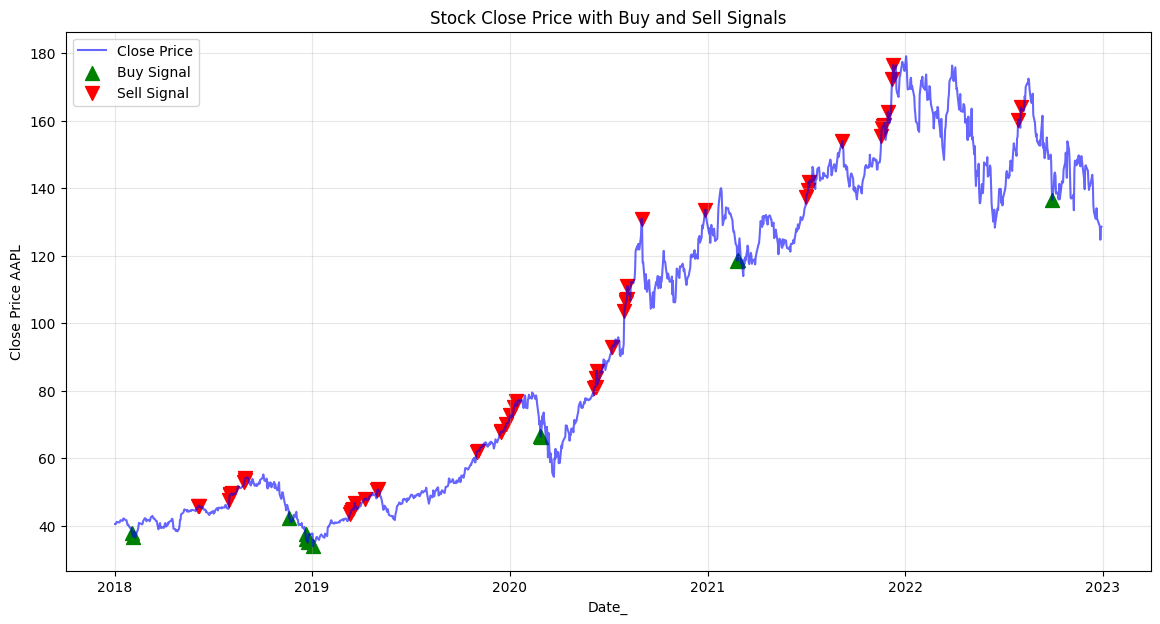

In [307]:
import matplotlib.pyplot as plt

# Filter rows with buy and sell signals
buy_signals = stock_data[stock_data['Signal_T'] == 1]
sell_signals = stock_data[stock_data['Signal_T'] == -1]

# Plot the stock's Close price
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Date_'], stock_data[f'Close_{ticker}'], label='Close Price', color='blue', alpha=0.6)

# Add buy signals to the plot
plt.scatter(buy_signals['Date_'], buy_signals[f'Close_{ticker}'], label='Buy Signal', marker='^', color='green', s=100)

# Add sell signals to the plot
plt.scatter(sell_signals['Date_'], sell_signals[f'Close_{ticker}'], label='Sell Signal', marker='v', color='red', s=100)

# Plot enhancements
plt.title('Stock Close Price with Buy and Sell Signals')
plt.xlabel('Date_')
plt.ylabel(f'Close Price {ticker}')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

#### Integrate SMA Indicator Strategy
- If SMA 50 > SMA 200: Buy Indicator
- If SMA 50 < SMA 200: Sell Indicator


In [308]:
# Create label for SMA Buy or Sell.
# 1 = Buy
# 0 = Hold
# -1 = Sell
sma_label = 0

# Get SMA50 and SMA200
stock_data[f"SMA50_{ticker}"] = stock_data[f"Close_{ticker}"].rolling(window=50).mean()
stock_data[f"SMA200_{ticker}"] = stock_data[f"Close_{ticker}"].rolling(window=200).mean()

stock_data['sma_label'] = 0

# Label signals
stock_data.loc[(stock_data[f"SMA50_{ticker}"] > stock_data[f"SMA200_{ticker}"]), 'sma_label'] = 1
stock_data.loc[(stock_data[f"SMA50_{ticker}"] < stock_data[f"SMA200_{ticker}"]), 'sma_label'] = -1

If SMA label and previous Signal labels are equal, we buy or sell.

In [309]:


# Generate Buy Signal: RSI < 30, Close below Lower Bollinger Band, and SMA Buy
stock_data.loc[
    (stock_data['Signal_T'] == 1) &
    (stock_data['sma_label'] == 1),
    'Signal'
] = 1  # Buy signal

# Generate Sell Signal: RSI > 70, Close above Upper Bollinger Band, and SMA Sell
stock_data.loc[
    (stock_data['Signal_T'] == -1) &
    (stock_data['sma_label'] == -1),
    'Signal'
] = -1  # Sell signal

stock_data['Signal'] = stock_data['Signal'].fillna(0)


# Save the DataFrame to a CSV file
stock_data.to_csv('stock_data.csv', index=False)

print("Data saved to 'stock_data.csv'")


Data saved to 'stock_data.csv'


Plot the signals

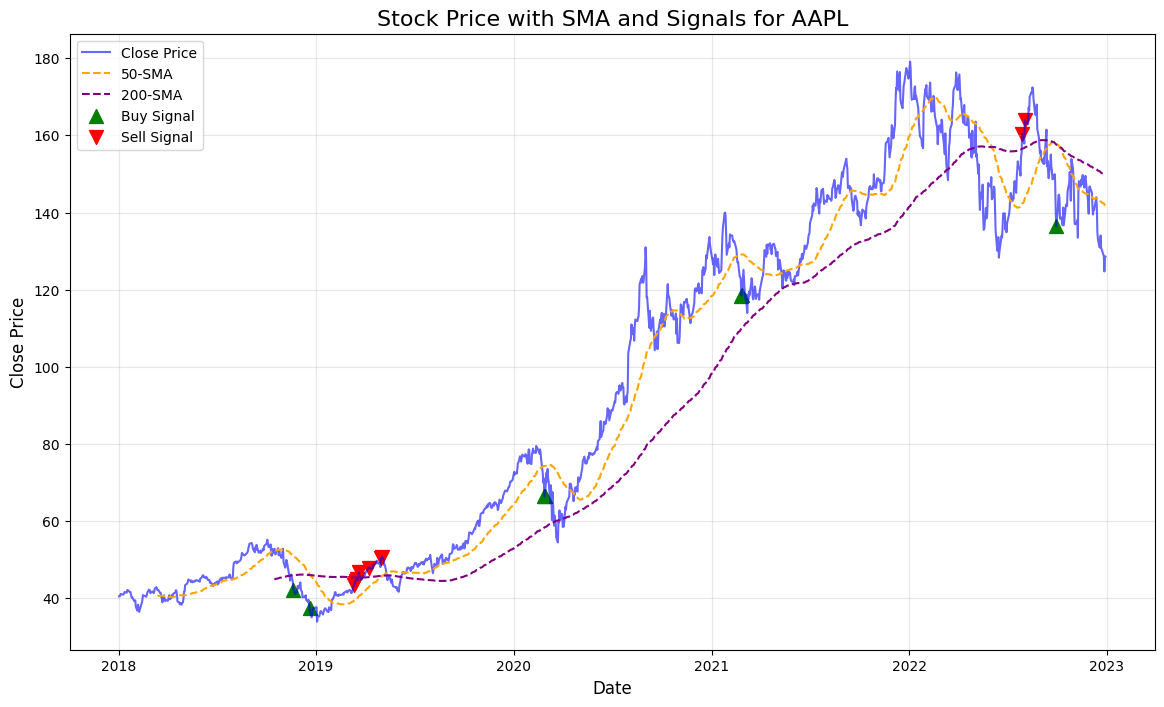

In [310]:
import matplotlib.pyplot as plt

# Plot Close Price
plt.figure(figsize=(14, 8))
plt.plot(stock_data['Date_'], stock_data[f"Close_{ticker}"], label='Close Price', color='blue', alpha=0.6)

# Add SMA50 and SMA200
plt.plot(stock_data['Date_'], stock_data[f"SMA50_{ticker}"], label='50-SMA', color='orange', linestyle='--')
plt.plot(stock_data['Date_'], stock_data[f"SMA200_{ticker}"], label='200-SMA', color='purple', linestyle='--')

# Highlight Buy and Sell signals
buy_signals = stock_data[stock_data['Signal'] == 1]
sell_signals = stock_data[stock_data['Signal'] == -1]
plt.scatter(buy_signals['Date_'], buy_signals[f"Close_{ticker}"], label='Buy Signal', marker='^', color='green', s=100)
plt.scatter(sell_signals['Date_'], sell_signals[f"Close_{ticker}"], label='Sell Signal', marker='v', color='red', s=100)

# Add titles and labels
plt.title(f'Stock Price with SMA and Signals for {ticker}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Close Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.show()